<a href="https://colab.research.google.com/github/spooki-chan/CS-31_SDGP/blob/sub/RecommedationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hybrid Recommendation System


In [ ]:
# Importing frameworks
import pandas as pd
import numpy as np
import ast 
from ast import literal_eval




In [ ]:
df = pd.read_csv("/content/newfood.csv")

In [ ]:
df.head()

,id,title,pricePerServing,weightPerServing,vegetarian,vegan,glutenFree,dairyFree,sustainable,veryHealthy,veryPopular,gaps,lowFodmap,ketogenic,whole30,readyInMinutes,spoonacularSourceUrl,image,aggregateLikes,spoonacularScore,healthScore,percentProtein,percentFat,percentCarbs,dishTypes,ingredients,calories,Fat/g,Saturated Fat/g,Carbohydrates/g,Sugar/g,Cholesterol/mg,Sodium/mg,Protein/g,Vitamin B3/mg,Selenium/µg,Phosphorus/mg,Iron/mg,Vitamin B2/mg,Calcium/mg,Vitamin B1/mg,Folate/µg,Potassium/mg,Copper/mg,Zinc/mg,Manganese/mg,Magnesium/mg,Vitamin B12/µg,Vitamin B5/mg,Vitamin B6/mg,Vitamin E/mg,Fiber/g,Vitamin A/IU,Vitamin D/µg,Vitamin K/µg,Vitamin C/mg,Alcohol/g,Caffeine/g,stars,popularity
0,1,Fried Anchovies with Sage,5.6051,226,False,False,False,True,False,False,False,no,False,False,False,45,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/recipeImages/1-556x370...,3,75,29,39.64,25.43,34.93,[Maindish],"anchovies,baking powder,egg,flour,sage leaves,...",384.09,10.53,3.60,32.53,0.17,145.28,955.48,36.92,23.67,73.82,428.72,7.22,0.66,295.10,0.42,96.75,778.81,0.43,3.09,0.40,73.36,1.07,1.38,0.26,1.09,1.16,154.80,0.29,0.00,0.00,0.0,0.0,3,150.437577
1,2,Anchovies Appetizer With Breadcrumbs & Scallions,0.8206,33,False,False,False,True,False,False,False,no,False,False,False,15,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/recipeImages/2-556x370...,1535,32,4,36.52,36.52,26.96,[Starter],"anchovies,bread,garlic clove,olive oil,scallions",57.07,2.28,0.47,3.79,0.50,12.76,59.43,5.13,3.42,9.85,49.24,0.99,0.08,43.55,0.05,9.86,103.37,0.06,0.46,0.11,12.62,0.13,0.20,0.04,0.29,0.38,0.00,0.00,7.18,0.00,0.0,0.0,1,139.082615
2,3,"Carrots, Cauliflower And Anchovies",4.3800,364,False,False,False,True,False,True,False,no,False,False,False,45,https://spoonacular.com/carrots-cauliflower-an...,https://spoonacular.com/recipeImages/3-556x370...,1535,83,63,6.74,66.86,26.40,[Maindish],"acini di pepe,almonds,anchovies,carrots,caulif...",942.08,72.72,9.00,64.61,11.09,1.92,296.97,16.51,2.86,2.24,223.51,4.49,0.43,207.76,0.18,96.54,848.60,0.41,1.53,1.03,122.71,0.00,0.78,0.27,17.01,9.99,21572.42,0.00,104.27,32.60,0.0,0.0,4,107.376788
3,4,Bap Story: Stir Fried Anchovies (Myulchi Bokkeum),8.1122,711,False,False,True,True,False,True,False,no,False,False,False,45,https://spoonacular.com/bap-story-stir-fried-a...,https://spoonacular.com/recipeImages/4-556x370...,11,94,70,29.89,64.41,5.70,[Maindish],"anchovies,baby-back ribs,cooking oil,frying oi...",1697.23,122.21,36.39,24.30,14.09,436.23,583.67,127.61,50.14,207.74,1139.83,9.35,1.99,406.70,2.76,19.75,1875.89,1.22,17.27,2.30,187.05,3.64,5.24,2.73,5.23,2.10,180.52,6.24,16.02,3.88,0.0,0.0,3,112.312950
4,5,"Bread, Butter And Anchovies",0.2557,36,False,False,False,False,False,False,False,no,False,False,False,3,https://spoonacular.com/bread-butter-and-ancho...,https://spoonacular.com/recipeImages/5-556x370...,420,14,1,11.01,39.96,49.03,[Maindish],"bread,capers,salted anchovies,unsalted butter",112.75,5.05,2.80,13.95,1.71,10.75,276.25,3.13,1.68,8.14,44.24,1.02,0.08,40.64,0.13,24.41,52.96,0.05,0.34,0.34,13.64,0.00,0.24,0.03,0.19,1.24,128.27,0.00,2.21,0.00,0.0,0.0,5,43.926995


Removing Unwanted Columns In the Dataset

In [ ]:
df.drop(labels=['vegetarian','vegan', 'glutenFree', 'dairyFree', 'sustainable', 'weightPerServing','pricePerServing', 'gaps', 'lowFodmap', 'ketogenic'],axis=1, inplace=True)
df.drop(labels=['whole30','spoonacularScore', 'Vitamin B5/mg', 'Vitamin B6/mg', 'healthScore','percentProtein', 'percentFat', 'Magnesium/mg', 'Vitamin B12/µg'],axis=1, inplace=True)
df.drop(labels=['percentCarbs','Zinc/mg', 'Manganese/mg', 'Fiber/g', 'Vitamin E/mg','Vitamin B1/mg', 'Folate/µg', 'Potassium/mg', 'Copper/mg','Vitamin A/IU','Vitamin D/µg','Vitamin K/µg'],axis=1, inplace=True)
df.drop(labels=['Fat/g','Saturated Fat/g', 'Carbohydrates/g','Cholesterol/mg','Sodium/mg','Protein/g','Vitamin B3/mg','Selenium/µg','Phosphorus/mg','Iron/mg','Vitamin B2/mg','Calcium/mg','Vitamin C/mg','Alcohol/g','Caffeine/g'],axis=1, inplace=True)


In [ ]:
df.head()

,id,title,veryHealthy,veryPopular,readyInMinutes,spoonacularSourceUrl,image,aggregateLikes,dishTypes,ingredients,calories,Sugar/g,stars,popularity
0,1,Fried Anchovies with Sage,False,False,45,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/recipeImages/1-556x370...,3,[Maindish],"anchovies,baking powder,egg,flour,sage leaves,...",384.09,0.17,3,150.437577
1,2,Anchovies Appetizer With Breadcrumbs & Scallions,False,False,15,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/recipeImages/2-556x370...,1535,[Starter],"anchovies,bread,garlic clove,olive oil,scallions",57.07,0.50,1,139.082615
2,3,"Carrots, Cauliflower And Anchovies",True,False,45,https://spoonacular.com/carrots-cauliflower-an...,https://spoonacular.com/recipeImages/3-556x370...,1535,[Maindish],"acini di pepe,almonds,anchovies,carrots,caulif...",942.08,11.09,4,107.376788
3,4,Bap Story: Stir Fried Anchovies (Myulchi Bokkeum),True,False,45,https://spoonacular.com/bap-story-stir-fried-a...,https://spoonacular.com/recipeImages/4-556x370...,11,[Maindish],"anchovies,baby-back ribs,cooking oil,frying oi...",1697.23,14.09,3,112.312950
4,5,"Bread, Butter And Anchovies",False,False,3,https://spoonacular.com/bread-butter-and-ancho...,https://spoonacular.com/recipeImages/5-556x370...,420,[Maindish],"bread,capers,salted anchovies,unsalted butter",112.75,1.71,5,43.926995


In [ ]:
df['recommend'] = np.nan
df['recommend'] = df['recommend'].astype('str')

df["stars"] = df["stars"].astype("int64", errors='ignore')

for i in df['veryHealthy'].index: 
  if(False==df['veryHealthy'][i] ): 
    df['recommend'][i]='No' 
  elif(True==df['veryHealthy'][i] ): 
    df['recommend'][i]='Yes'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df.head()

,id,title,veryHealthy,veryPopular,readyInMinutes,spoonacularSourceUrl,image,aggregateLikes,dishTypes,ingredients,calories,Sugar/g,stars,popularity,recommend
0,1,Fried Anchovies with Sage,False,False,45,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/recipeImages/1-556x370...,3,[Maindish],"anchovies,baking powder,egg,flour,sage leaves,...",384.09,0.17,3,150.437577,No
1,2,Anchovies Appetizer With Breadcrumbs & Scallions,False,False,15,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/recipeImages/2-556x370...,1535,[Starter],"anchovies,bread,garlic clove,olive oil,scallions",57.07,0.50,1,139.082615,No
2,3,"Carrots, Cauliflower And Anchovies",True,False,45,https://spoonacular.com/carrots-cauliflower-an...,https://spoonacular.com/recipeImages/3-556x370...,1535,[Maindish],"acini di pepe,almonds,anchovies,carrots,caulif...",942.08,11.09,4,107.376788,Yes
3,4,Bap Story: Stir Fried Anchovies (Myulchi Bokkeum),True,False,45,https://spoonacular.com/bap-story-stir-fried-a...,https://spoonacular.com/recipeImages/4-556x370...,11,[Maindish],"anchovies,baby-back ribs,cooking oil,frying oi...",1697.23,14.09,3,112.312950,Yes
4,5,"Bread, Butter And Anchovies",False,False,3,https://spoonacular.com/bread-butter-and-ancho...,https://spoonacular.com/recipeImages/5-556x370...,420,[Maindish],"bread,capers,salted anchovies,unsalted butter",112.75,1.71,5,43.926995,No


STAR COMPARE WITH RECOMMENDED

In [ ]:
df.columns

Index(['id', 'title', 'veryHealthy', 'veryPopular', 'readyInMinutes',
       'spoonacularSourceUrl', 'image', 'aggregateLikes', 'dishTypes',
       'ingredients', 'calories', 'Sugar/g', 'stars', 'popularity',
       'recommend'],
      dtype='object')



*   Id : for food numbers
*   title : Food name
*   veryHealthy :
*   veryPopular :
*   readyInMinutes :
*   image :
*   dishTypes :
*   ingredients :
*   calories :
*   stars :
*   recommend :












In [ ]:
df.iloc[0:3].transpose()

,0,1,2
id,1,2,3
title,Fried Anchovies with Sage,Anchovies Appetizer With Breadcrumbs & Scallions,"Carrots, Cauliflower And Anchovies"
veryHealthy,False,False,True
veryPopular,False,False,False
readyInMinutes,45,15,45
spoonacularSourceUrl,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/carrots-cauliflower-an...
image,https://spoonacular.com/recipeImages/1-556x370...,https://spoonacular.com/recipeImages/2-556x370...,https://spoonacular.com/recipeImages/3-556x370...
aggregateLikes,3,1535,1535
dishTypes,[Maindish],[Starter],[Maindish]
ingredients,"anchovies,baking powder,egg,flour,sage leaves,...","anchovies,bread,garlic clove,olive oil,scallions","acini di pepe,almonds,anchovies,carrots,caulif..."


In [ ]:
df.shape

(1722, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1722 entries, 0 to 1721
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1722 non-null   int64  
 1   title                 1722 non-null   object 
 2   veryHealthy           1722 non-null   bool   
 3   veryPopular           1722 non-null   bool   
 4   readyInMinutes        1722 non-null   int64  
 5   spoonacularSourceUrl  1722 non-null   object 
 6   image                 1718 non-null   object 
 7   aggregateLikes        1722 non-null   int64  
 8   dishTypes             1722 non-null   object 
 9   ingredients           1722 non-null   object 
 10  calories              1722 non-null   float64
 11  Sugar/g               1722 non-null   float64
 12  stars                 1722 non-null   int64  
 13  popularity            1722 non-null   float64
 14  recommend             1722 non-null   object 
dtypes: bool(2), float64(3

In [ ]:
v=df['aggregateLikes']
R=df['stars']
C=df['stars'].mean()
m=df['aggregateLikes'].quantile(0.95)

In [ ]:
df.iloc[0:3].transpose()

,0,1,2
id,1,2,3
title,Fried Anchovies with Sage,Anchovies Appetizer With Breadcrumbs & Scallions,"Carrots, Cauliflower And Anchovies"
veryHealthy,False,False,True
veryPopular,False,False,False
readyInMinutes,45,15,45
spoonacularSourceUrl,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/carrots-cauliflower-an...
image,https://spoonacular.com/recipeImages/1-556x370...,https://spoonacular.com/recipeImages/2-556x370...,https://spoonacular.com/recipeImages/3-556x370...
aggregateLikes,3,1535,1535
dishTypes,[Maindish],[Starter],[Maindish]
ingredients,"anchovies,baking powder,egg,flour,sage leaves,...","anchovies,bread,garlic clove,olive oil,scallions","acini di pepe,almonds,anchovies,carrots,caulif..."


In [ ]:
df['weighted_average']=((R*v)+ (C*m))/(v+m)

In [ ]:
df

,id,title,veryHealthy,veryPopular,readyInMinutes,spoonacularSourceUrl,image,aggregateLikes,dishTypes,ingredients,calories,Sugar/g,stars,popularity,recommend,weighted_average
0,1,Fried Anchovies with Sage,False,False,45,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/recipeImages/1-556x370...,3,[Maindish],"anchovies,baking powder,egg,flour,sage leaves,...",384.09,0.17,3,150.437577,No,3.919406
1,2,Anchovies Appetizer With Breadcrumbs & Scallions,False,False,15,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/recipeImages/2-556x370...,1535,[Starter],"anchovies,bread,garlic clove,olive oil,scallions",57.07,0.50,1,139.082615,No,2.852950
2,3,"Carrots, Cauliflower And Anchovies",True,False,45,https://spoonacular.com/carrots-cauliflower-an...,https://spoonacular.com/recipeImages/3-556x370...,1535,[Maindish],"acini di pepe,almonds,anchovies,carrots,caulif...",942.08,11.09,4,107.376788,Yes,3.949522
3,4,Bap Story: Stir Fried Anchovies (Myulchi Bokkeum),True,False,45,https://spoonacular.com/bap-story-stir-fried-a...,https://spoonacular.com/recipeImages/4-556x370...,11,[Maindish],"anchovies,baby-back ribs,cooking oil,frying oi...",1697.23,14.09,3,112.312950,Yes,3.916657
4,5,"Bread, Butter And Anchovies",False,False,3,https://spoonacular.com/bread-butter-and-ancho...,https://spoonacular.com/recipeImages/5-556x370...,420,[Maindish],"bread,capers,salted anchovies,unsalted butter",112.75,1.71,5,43.926995,No,4.067442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,1995,Blackened Salmon Fillets,False,False,25,https://spoonacular.com/blackened-salmon-fille...,https://spoonacular.com/recipeImages/1995-556x...,493,[Maindish],"dried basil,dried thyme,ground cayenne pepper,...",466.57,0.63,3,37.729059,No,3.776725
1718,1996,Vegetable Stew With Halibut,False,False,37,https://spoonacular.com/vegetable-stew-with-ha...,https://spoonacular.com/recipeImages/1996-556x...,433,[Starter],"cherry tomatoes,chicken broth,fresh corn kerne...",24.02,0.58,4,18.650748,No,3.931563
1719,1997,Snapper Tacos with Chipotle Cream,False,False,45,https://spoonacular.com/snapper-tacos-with-chi...,https://spoonacular.com/recipeImages/1997-556x...,1422,[Maindish],"butter,chipotle chile in adobo,flour tortillas...",418.20,7.52,3,15.794946,No,3.600147
1720,1998,Smoky Maple-glazed Salmon Supper,True,False,45,https://spoonacular.com/smoky-maple-glazed-sal...,https://spoonacular.com/recipeImages/1998-556x...,39,[Maindish],"brown rice,butter,carrots,chives,cider vinegar...",803.88,31.23,4,45.054936,Yes,3.921589


In [ ]:
df_sorted_recipes=df.sort_values('weighted_average',ascending=False)
df_sorted_recipes[['title', 'aggregateLikes', 'stars', 'weighted_average', 'popularity']].head(20)

,title,aggregateLikes,stars,weighted_average,popularity
1014,"Fish With Olives, Pine Nuts, Basil And Wine",11452,5,4.796236,18.600490
190,Bagna Cauda Dip With Assorted Vegetables,9635,5,4.766133,89.938296
77,"Roasted Brussels Sprouts With Capers, Walnuts ...",6423,5,4.683472,128.655964
1156,Bluefish (or Swordfish) With Preserved Lemons,5244,5,4.636284,25.219805
489,"Spaghetti With Caramelized Onions, Anchovies, ...",5235,5,4.635870,10.706613
78,Labneh With Chilli And Anchovy,4646,5,4.606532,94.199316
428,Salsa-Piqino,4645,5,4.606478,59.113174
1587,Poached Salmon With Corn And White Wine–butter...,4524,5,4.599854,30.380747
80,Pasta With Anchovy Bread Crumb Topping,4342,5,4.589460,77.178973
219,Pasta With Anchovy-walnut side dish,4244,5,4.583636,33.616115


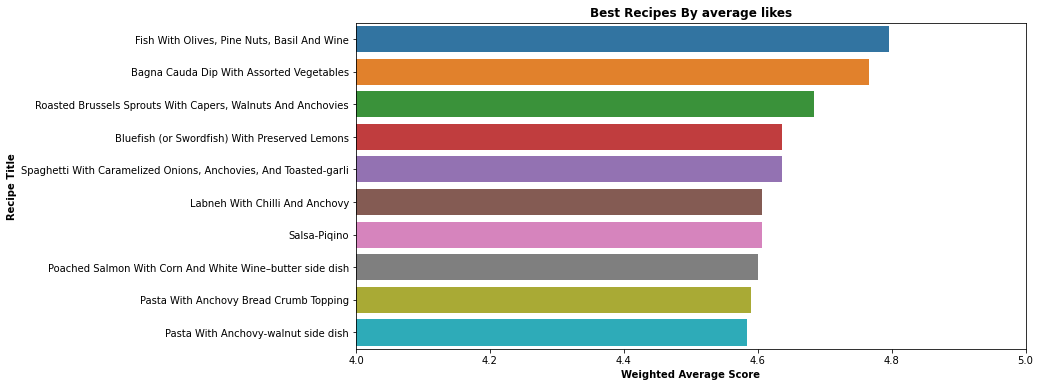

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

weight_average=df.sort_values('weighted_average',ascending=False)
plt.figure(figsize=(12,6))
axis1=sns.barplot(x=weight_average['weighted_average'].head(10), y=weight_average['title'].head(10), data=weight_average)
plt.xlim(4, 5)
plt.title('Best Recipes By average likes', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Recipe Title', weight='bold')
plt.savefig('best_recipes.png')

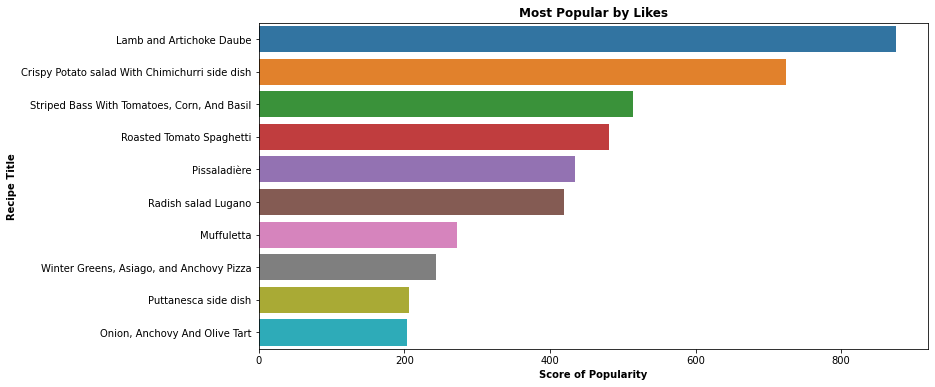

In [ ]:
popularity=df.sort_values('popularity',ascending=False)
plt.figure(figsize=(12,6))
ax=sns.barplot(x=popularity['popularity'].head(10), y=popularity['title'].head(10), data=popularity)

plt.title('Most Popular by Likes', weight='bold')
plt.xlabel('Score of Popularity', weight='bold')
plt.ylabel('Recipe Title', weight='bold')
plt.savefig('best_popular_recipes.png')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaling=MinMaxScaler()
recipe_scaled_df=scaling.fit_transform(df[['weighted_average','popularity']])
recipe_normalized_df=pd.DataFrame(recipe_scaled_df,columns=['weighted_average','popularity'])
recipe_normalized_df.head()

,weighted_average,popularity
0,0.810756,0.171695
1,0.580584,0.158724
2,0.817255,0.122508
3,0.810162,0.128146
4,0.842706,0.050031


In [ ]:
df[['normalized_weight_average','normalized_popularity']]= recipe_normalized_df

In [ ]:
df.head()

,id,title,veryHealthy,veryPopular,readyInMinutes,spoonacularSourceUrl,image,aggregateLikes,dishTypes,ingredients,calories,Sugar/g,stars,popularity,recommend,weighted_average,normalized_weight_average,normalized_popularity
0,1,Fried Anchovies with Sage,False,False,45,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/recipeImages/1-556x370...,3,[Maindish],"anchovies,baking powder,egg,flour,sage leaves,...",384.09,0.17,3,150.437577,No,3.919406,0.810756,0.171695
1,2,Anchovies Appetizer With Breadcrumbs & Scallions,False,False,15,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/recipeImages/2-556x370...,1535,[Starter],"anchovies,bread,garlic clove,olive oil,scallions",57.07,0.50,1,139.082615,No,2.852950,0.580584,0.158724
2,3,"Carrots, Cauliflower And Anchovies",True,False,45,https://spoonacular.com/carrots-cauliflower-an...,https://spoonacular.com/recipeImages/3-556x370...,1535,[Maindish],"acini di pepe,almonds,anchovies,carrots,caulif...",942.08,11.09,4,107.376788,Yes,3.949522,0.817255,0.122508
3,4,Bap Story: Stir Fried Anchovies (Myulchi Bokkeum),True,False,45,https://spoonacular.com/bap-story-stir-fried-a...,https://spoonacular.com/recipeImages/4-556x370...,11,[Maindish],"anchovies,baby-back ribs,cooking oil,frying oi...",1697.23,14.09,3,112.312950,Yes,3.916657,0.810162,0.128146
4,5,"Bread, Butter And Anchovies",False,False,3,https://spoonacular.com/bread-butter-and-ancho...,https://spoonacular.com/recipeImages/5-556x370...,420,[Maindish],"bread,capers,salted anchovies,unsalted butter",112.75,1.71,5,43.926995,No,4.067442,0.842706,0.050031


In [ ]:
df['score'] = df['normalized_weight_average'] * 0.5 + df['normalized_popularity'] * 0.5
recipe_scored_df = df.sort_values(['score'], ascending=False)
df[['title', 'normalized_weight_average', 'normalized_popularity', 'score']].head(20)

,title,normalized_weight_average,normalized_popularity,score
0,Fried Anchovies with Sage,0.810756,0.171695,0.491225
1,Anchovies Appetizer With Breadcrumbs & Scallions,0.580584,0.158724,0.369654
2,"Carrots, Cauliflower And Anchovies",0.817255,0.122508,0.469882
3,Bap Story: Stir Fried Anchovies (Myulchi Bokkeum),0.810162,0.128146,0.469154
4,"Bread, Butter And Anchovies",0.842706,0.050031,0.446369
5,Fried Anchovies,0.812830,0.132015,0.472423
6,"Tomato & Anchovies With Bread Crumbs, Basil & ...",0.811176,0.055463,0.433320
7,Marinated Fresh Anchovies: Alici Marinate,0.842966,0.153238,0.498102
8,Marinated Boquerones,0.817255,0.112809,0.465032
9,Spaghetti With Walnuts And Anchovies,0.836795,0.177809,0.507302


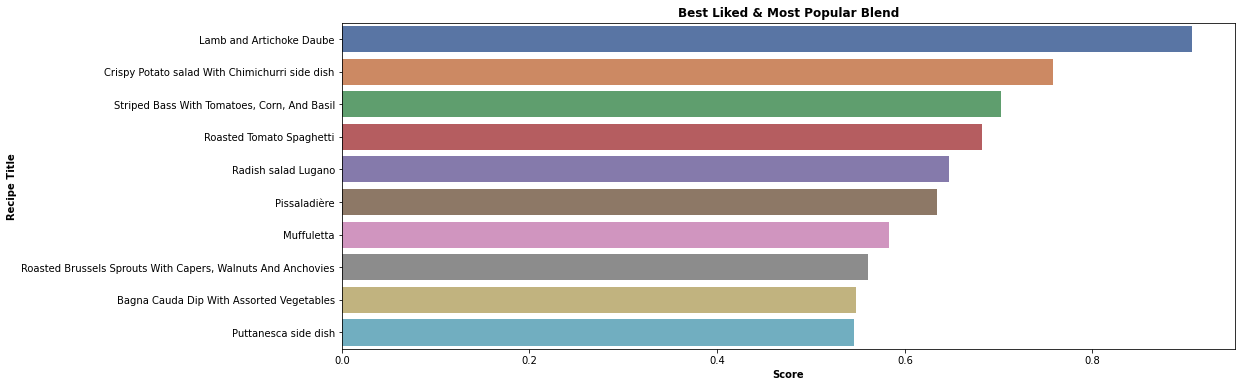

In [ ]:
scored_df = df.sort_values('score', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=scored_df['score'].head(10), y=scored_df['title'].head(10), data=scored_df, palette='deep')

#plt.xlim(3.55, 5.25)
plt.title('Best Liked & Most Popular Blend', weight='bold')
plt.xlabel('Score', weight='bold')
plt.ylabel('Recipe Title', weight='bold')

plt.savefig('scored_movies.png')